# Average and deviation std of the models for the fidelity (Cosine similarity)

### Cosine similarity ??????????

This thime we use the Frobenious product to derive the cosine between the two complex matrix
The cosine similarity between matrices \(A\) and \(B\) is given by:

$$
\text{cosine similarity} = \frac{\text{trace}(A^H B)}{\|A\|_F \|B\|_F}
$$

where:
- \(A^H\) is the conjugate transpose of \(A\),
- \(\text{Re}(\cdot)\) denotes taking the real part of the complex number,
- \(\|A\|_F\) and \(\|B\|_F\) are the Frobenius norms of \(A\) and \(B\), respectively.

Real part agle beween the real parts matrices and complex agle beween complex part matrices. We care like decetcor about the absolute value

In [1]:
import os
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Compute cosine similarity
def cosine_similarity(target_matrix, predicted_matrix):
    target_matrix_H = target_matrix.conj().T
    predicted_matrix_H = predicted_matrix.conj().T
    trace_tH_t = np.trace(np.dot(target_matrix_H, target_matrix)).real          # result is REAL
    trace_pH_p = np.trace(np.dot(predicted_matrix_H, predicted_matrix)).real    # result is REAL
    trace_pH_t = np.trace(np.dot(predicted_matrix_H, target_matrix))
    cosine_similarity = trace_pH_t/np.sqrt(trace_tH_t*trace_pH_p)
    cosine_similarity = np.abs(cosine_similarity)   # Take the abs 
    return cosine_similarity

In [3]:
# Extract targets and preditions from the simulation directory folder
def extract_targets_preditions_1sim(directory):
    target_tuples = []
    predit_tuples = []
    # Loop through each file in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)       # Construct the full file path
        if os.path.isfile(file_path):                       # Check if it is a file
            result_sim = np.load(file_path, allow_pickle=True)
            target_tuples.extend([(label, array) for label, array in result_sim if 'target' in label])
            predit_tuples.extend([(label, array) for label, array in result_sim if 'prediction' in label])
    return target_tuples, predit_tuples

In [4]:
# Derive the cosine_similarity for all one entire simulation
def remove_until_underscore(s):     # from the end until the first '_'
    parts = s.split('_')
    result = '_'.join(parts[1:])
    return result

def derive_cos_1sim(target_tuples, predit_tuples):
    fidelity = []
    for i in range(len(target_tuples)):
        if remove_until_underscore(target_tuples[i][0]) == remove_until_underscore(predit_tuples[i][0]):
            fidelity.extend([cosine_similarity(target_tuples[i][1], predit_tuples[i][1])])
        else:
            print("Capo abbiamo un problema :(")
    labels = [t[0] for t in predit_tuples]
    fidelity_pd = pd.DataFrame({'label': labels, 'value': fidelity})
    return fidelity_pd

In [5]:
# Take best result MAXIMUM value repetition
def models_repmax_mean_devstd(df, name_models):
    # Extracting the base label (e.g., 'LabelA', 'LabelB')
    df['label_no_rep'] = df['label'].apply(lambda x: x.split('_rep')[0])
    # Group with the base label and find max
    max_lastFidelity_s = df.groupby('label_no_rep')['value'].max()

    mean_models= []
    std_dev_models =[]
    for name in name_models:
        # model_s take the all 1000 sim same model with the best repetition value
        model_s = max_lastFidelity_s[max_lastFidelity_s.index.str.contains(name)]
        mean_models.append(model_s.mean())
        std_dev_models.append(model_s.std())
    return mean_models, std_dev_models

# SAVE everything
[(simulation hyp, name model, average, deviation std)]

In [6]:
directory_run = 'outdata/20240525_run_IMPORTANT'
name_models = ['Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct', 'NEUROPULS_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell2_Arct']

ave_devstd_run = []

for filename in os.listdir(directory_run):
    directory_path = os.path.join(directory_run, filename)       # Construct the full file path
    if not os.path.isfile(directory_path):
        target_tuples, predit_tuples = extract_targets_preditions_1sim(directory_path)
        cos_pd = derive_cos_1sim(target_tuples, predit_tuples)
        mean_models, std_dev_models = models_repmax_mean_devstd(cos_pd, name_models)
        last_folder_name = os.path.basename(directory_path)
        for name, mean, std_dev in zip(name_models, mean_models, std_dev_models):
            new_data = [(last_folder_name, name, mean, std_dev)]
            ave_devstd_run.extend(new_data)

dt = np.dtype([
    ('simulation', 'U100'),
    ('model', 'U100'),
    ('average', 'f4'),
    ('std_dev', 'f4')
])
ave_devstd_run_nparray = np.array(ave_devstd_run, dtype=dt)
np.save(directory_run+'/20240525_run_ave_dev_cos.npy', ave_devstd_run_nparray)

# Grapth

In [7]:
# Extrat the iloss and imb from the simulation label
def extract_values(label):
    match = re.search(r'iloss([0-9\.]+)_imb([0-9\.]+)', label)
    if match:
        return float(match.group(1)), float(match.group(2))
    return None, None

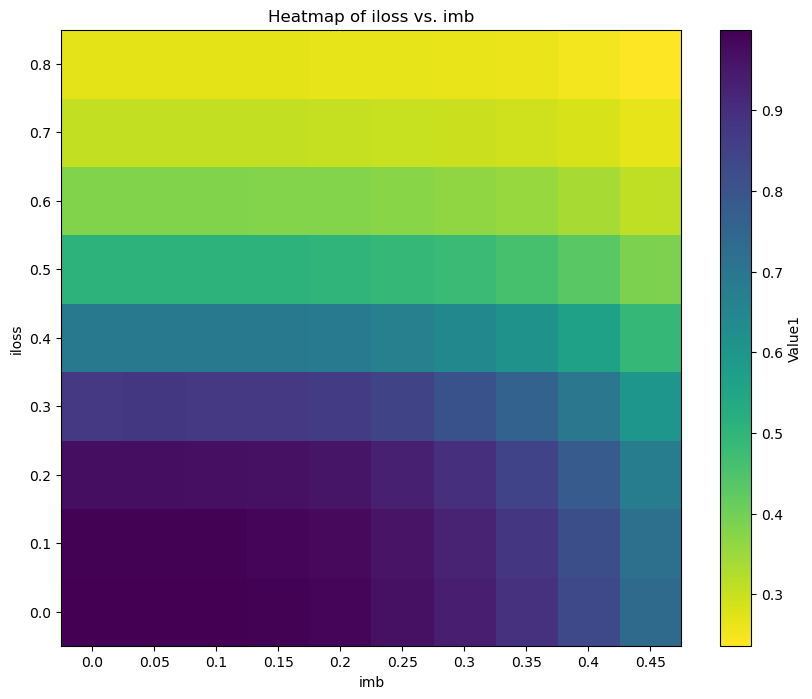

imb,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45
iloss,,,,,,,,,,
0.0,1.000000,0.999951,0.999198,0.995901,0.986440,0.966319,0.934749,0.891493,0.831729,0.737157
0.1,0.995353,0.995307,0.994506,0.990899,0.980839,0.959564,0.925397,0.878936,0.816151,0.718020
0.2,0.970523,0.970498,0.970015,0.966513,0.955859,0.933601,0.896116,0.846145,0.779622,0.675528
0.3,0.874533,0.874683,0.874269,0.872792,0.863150,0.842373,0.807523,0.759527,0.697188,0.598862
0.4,0.691655,0.691676,0.691721,0.690122,0.683362,0.667818,0.642112,0.607651,0.562485,0.490926
0.5,0.507192,0.507146,0.507008,0.505647,0.501597,0.492513,0.478165,0.458191,0.430161,0.385493
0.6,0.380595,0.380579,0.380293,0.379265,0.376702,0.371832,0.364269,0.353297,0.337395,0.309852
0.7,0.307477,0.307427,0.307069,0.306166,0.304470,0.301622,0.297321,0.291004,0.281220,0.263304
0.8,0.267906,0.267838,0.267556,0.266957,0.265896,0.264133,0.261348,0.256967,0.249781,0.236076


In [9]:
directory_run = 'outdata/20240525_run_IMPORTANT'
name_models = ['Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct', 'NEUROPULS_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell2_Arct']
name_model = 'Clements_Arct'

ave_devstd_run = np.load(directory_run+'/20240525_run_ave_dev_cos.npy', allow_pickle=True)
ave_devstd_df = pd.DataFrame(ave_devstd_run)
ave_devstd_df[['iloss', 'imb']] = ave_devstd_df['simulation'].apply(lambda x: pd.Series(extract_values(x)))
ave_devstd_filtered_model_df = ave_devstd_df[ave_devstd_df['model'] == name_model]
heatmap_data = ave_devstd_filtered_model_df.pivot_table(index='iloss', columns='imb', values='average')

# Plot the heatmap using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(heatmap_data, aspect='auto', cmap='viridis_r', origin='lower')
plt.colorbar(label='Value1')
plt.title('Heatmap of iloss vs. imb')
plt.xlabel('imb')
plt.ylabel('iloss')
# Set ticks for x and y axis
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)
plt.show()

heatmap_data

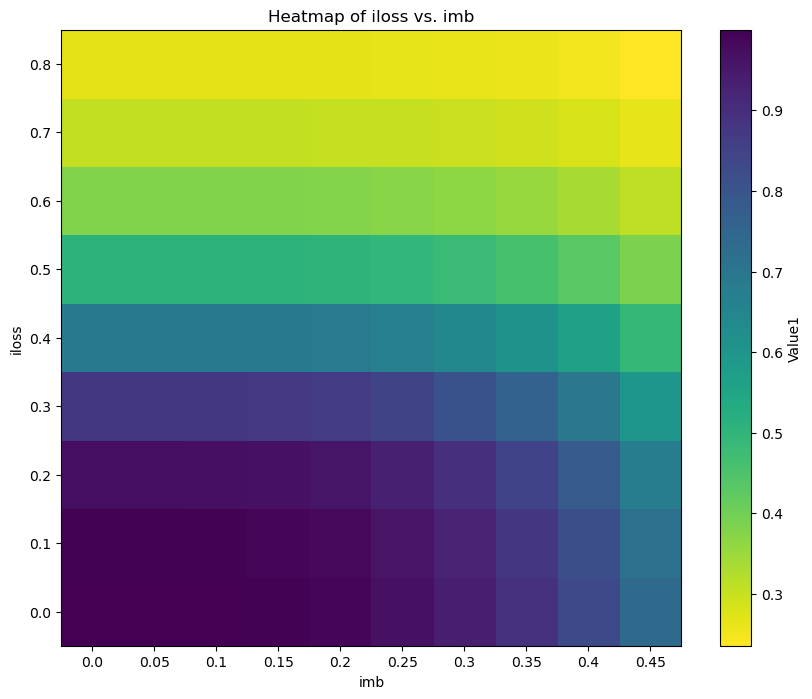

imb,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45
iloss,,,,,,,,,,
0.0,1.000000,0.999952,0.999197,0.995901,0.986433,0.966556,0.934527,0.891700,0.831735,0.737175
0.1,0.995350,0.995308,0.994500,0.990878,0.980758,0.959653,0.925534,0.879376,0.815921,0.717883
0.2,0.970603,0.970621,0.970042,0.966496,0.955929,0.933258,0.896155,0.846333,0.779359,0.675430
0.3,0.875134,0.875180,0.874812,0.872857,0.864284,0.842296,0.807011,0.760196,0.697209,0.598906
0.4,0.691945,0.691989,0.692042,0.690349,0.683760,0.667677,0.642080,0.607815,0.562409,0.490828
0.5,0.507052,0.507088,0.506879,0.505444,0.501420,0.492529,0.477950,0.458024,0.430068,0.385125
0.6,0.380338,0.380314,0.380034,0.379005,0.376453,0.371651,0.364085,0.353073,0.337087,0.309520
0.7,0.307256,0.307205,0.306846,0.305937,0.304239,0.301382,0.297068,0.290725,0.280905,0.262932
0.8,0.267629,0.267557,0.267279,0.266683,0.265618,0.263853,0.261053,0.256661,0.249431,0.235683


In [10]:
directory_run = 'outdata/20240525_run_IMPORTANT'
name_models = ['Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct', 'NEUROPULS_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell2_Arct']
name_model = 'ClementsBell_Arct'

ave_devstd_run = np.load(directory_run+'/20240525_run_ave_dev_cos.npy', allow_pickle=True)
ave_devstd_df = pd.DataFrame(ave_devstd_run)
ave_devstd_df[['iloss', 'imb']] = ave_devstd_df['simulation'].apply(lambda x: pd.Series(extract_values(x)))
ave_devstd_filtered_model_df = ave_devstd_df[ave_devstd_df['model'] == name_model]
heatmap_data = ave_devstd_filtered_model_df.pivot_table(index='iloss', columns='imb', values='average')

# Plot the heatmap using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(heatmap_data, aspect='auto', cmap='viridis_r', origin='lower')
plt.colorbar(label='Value1')
plt.title('Heatmap of iloss vs. imb')
plt.xlabel('imb')
plt.ylabel('iloss')
# Set ticks for x and y axis
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)
plt.show()

heatmap_data

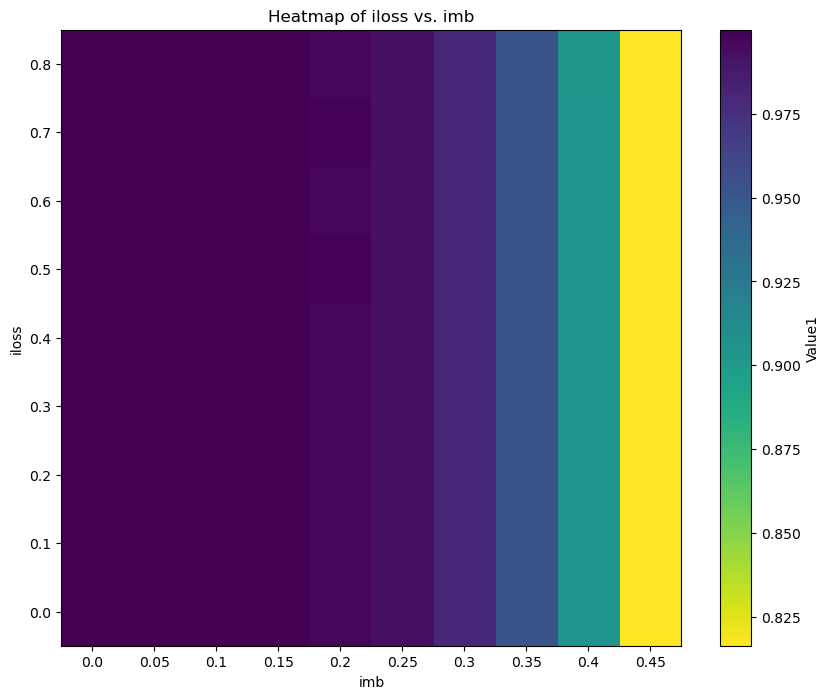

imb,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45
iloss,,,,,,,,,,
0.0,0.999982,0.999967,0.999852,0.999429,0.997828,0.992399,0.979696,0.952401,0.903252,0.816503
0.1,0.999982,0.999967,0.999852,0.999429,0.997827,0.992396,0.979695,0.952401,0.903252,0.816511
0.2,0.999982,0.999967,0.999853,0.999433,0.997830,0.992396,0.979695,0.952401,0.903251,0.816511
0.3,0.999982,0.999967,0.999854,0.999429,0.997830,0.992396,0.979688,0.952411,0.903251,0.816507
0.4,0.999982,0.999967,0.999854,0.999429,0.997828,0.992398,0.979714,0.952395,0.903251,0.816511
0.5,0.999982,0.999967,0.999853,0.999429,0.997834,0.992400,0.979709,0.952396,0.903257,0.816509
0.6,0.999979,0.999966,0.999855,0.999433,0.997825,0.992397,0.979681,0.952409,0.903269,0.816513
0.7,0.999979,0.999965,0.999860,0.999422,0.997837,0.992418,0.979647,0.952400,0.903263,0.816523
0.8,0.999976,0.999960,0.999855,0.999404,0.997695,0.992274,0.979435,0.952230,0.903034,0.816494


In [11]:
directory_run = 'outdata/20240525_run_IMPORTANT'
name_models = ['Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct', 'NEUROPULS_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell2_Arct']
name_model = 'Fldzhyan_Arct'

ave_devstd_run = np.load(directory_run+'/20240525_run_ave_dev_cos.npy', allow_pickle=True)
ave_devstd_df = pd.DataFrame(ave_devstd_run)
ave_devstd_df[['iloss', 'imb']] = ave_devstd_df['simulation'].apply(lambda x: pd.Series(extract_values(x)))
ave_devstd_filtered_model_df = ave_devstd_df[ave_devstd_df['model'] == name_model]
heatmap_data = ave_devstd_filtered_model_df.pivot_table(index='iloss', columns='imb', values='average')

# Plot the heatmap using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(heatmap_data, aspect='auto', cmap='viridis_r', origin='lower')
plt.colorbar(label='Value1')
plt.title('Heatmap of iloss vs. imb')
plt.xlabel('imb')
plt.ylabel('iloss')
# Set ticks for x and y axis
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)
plt.show()

heatmap_data

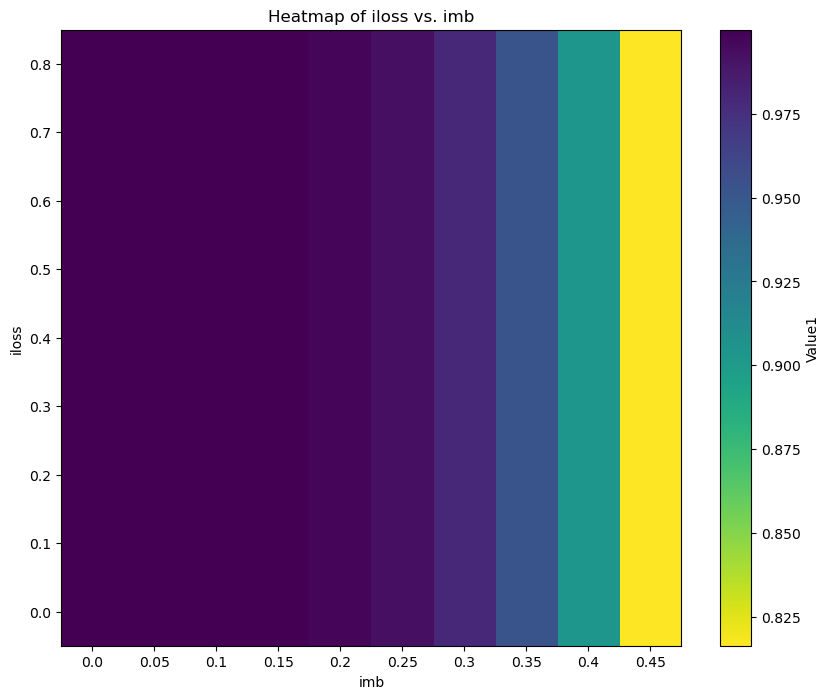

imb,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45
iloss,,,,,,,,,,
0.0,0.999988,0.999955,0.999886,0.999484,0.997740,0.992640,0.979345,0.952077,0.903679,0.816471
0.1,0.999988,0.999955,0.999887,0.999484,0.997745,0.992640,0.979345,0.952078,0.903679,0.816471
0.2,0.999988,0.999954,0.999887,0.999484,0.997746,0.992641,0.979347,0.952078,0.903679,0.816471
0.3,0.999988,0.999954,0.999888,0.999482,0.997752,0.992640,0.979347,0.952077,0.903679,0.816471
0.4,0.999989,0.999954,0.999887,0.999479,0.997767,0.992641,0.979343,0.952079,0.903660,0.816471
0.5,0.999989,0.999955,0.999887,0.999482,0.997763,0.992636,0.979366,0.952106,0.903673,0.816471
0.6,0.999988,0.999954,0.999886,0.999478,0.997759,0.992649,0.979406,0.952102,0.903646,0.816501
0.7,0.999987,0.999954,0.999887,0.999477,0.997786,0.992649,0.979385,0.952133,0.903690,0.816528
0.8,0.999990,0.999953,0.999870,0.999504,0.997740,0.992695,0.979355,0.952160,0.903675,0.816524


In [12]:
directory_run = 'outdata/20240525_run_IMPORTANT'
name_models = ['Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct', 'NEUROPULS_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell2_Arct']
name_model = 'FldzhyanBell_Arct'

ave_devstd_run = np.load(directory_run+'/20240525_run_ave_dev_cos.npy', allow_pickle=True)
ave_devstd_df = pd.DataFrame(ave_devstd_run)
ave_devstd_df[['iloss', 'imb']] = ave_devstd_df['simulation'].apply(lambda x: pd.Series(extract_values(x)))
ave_devstd_filtered_model_df = ave_devstd_df[ave_devstd_df['model'] == name_model]
heatmap_data = ave_devstd_filtered_model_df.pivot_table(index='iloss', columns='imb', values='average')

# Plot the heatmap using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(heatmap_data, aspect='auto', cmap='viridis_r', origin='lower')
plt.colorbar(label='Value1')
plt.title('Heatmap of iloss vs. imb')
plt.xlabel('imb')
plt.ylabel('iloss')
# Set ticks for x and y axis
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)
plt.show()

heatmap_data

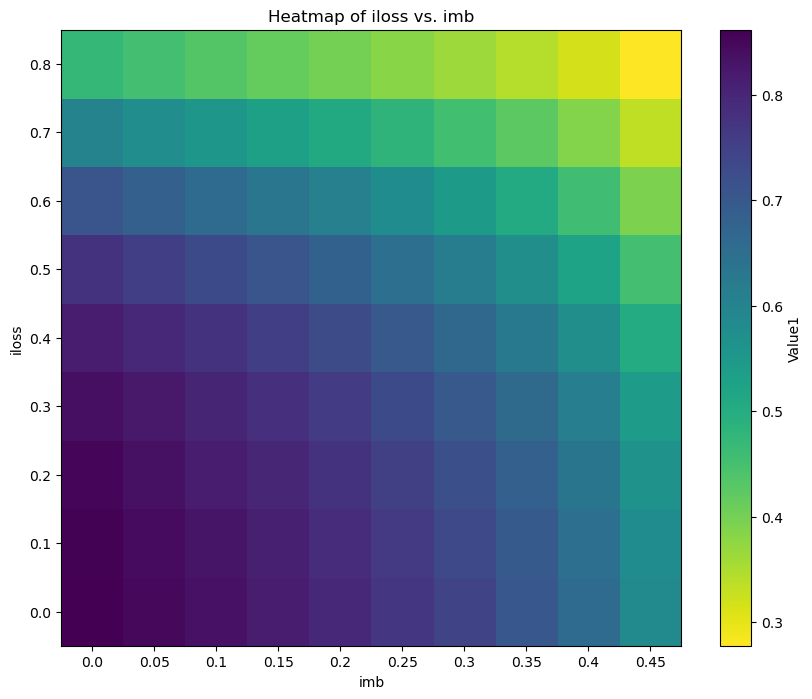

imb,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45
iloss,,,,,,,,,,
0.0,0.861547,0.848588,0.833066,0.815440,0.794067,0.769647,0.740842,0.704120,0.656422,0.584749
0.1,0.858220,0.844048,0.827404,0.809509,0.787570,0.762647,0.733144,0.696446,0.648764,0.577681
0.2,0.850911,0.835394,0.817991,0.799168,0.776160,0.750993,0.720047,0.682791,0.634481,0.563673
0.3,0.837430,0.820793,0.802199,0.781295,0.757826,0.730646,0.698546,0.660070,0.610782,0.539576
0.4,0.814693,0.795735,0.775049,0.752794,0.727979,0.698798,0.665482,0.625028,0.574132,0.502811
0.5,0.775615,0.753624,0.731585,0.706710,0.680392,0.649379,0.615103,0.573833,0.522504,0.452986
0.6,0.707399,0.682761,0.658408,0.632531,0.606459,0.577198,0.544058,0.505549,0.457403,0.393828
0.7,0.600257,0.576396,0.552731,0.530194,0.506173,0.482436,0.455329,0.424273,0.385484,0.332874
0.8,0.473713,0.453302,0.433972,0.416745,0.399440,0.382139,0.363583,0.342737,0.315973,0.277873


In [13]:
directory_run = 'outdata/20240525_run_IMPORTANT'
name_models = ['Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct', 'NEUROPULS_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell2_Arct']
name_model = 'FldzhyanBellHalf_Arct'

ave_devstd_run = np.load(directory_run+'/20240525_run_ave_dev_cos.npy', allow_pickle=True)
ave_devstd_df = pd.DataFrame(ave_devstd_run)
ave_devstd_df[['iloss', 'imb']] = ave_devstd_df['simulation'].apply(lambda x: pd.Series(extract_values(x)))
ave_devstd_filtered_model_df = ave_devstd_df[ave_devstd_df['model'] == name_model]
heatmap_data = ave_devstd_filtered_model_df.pivot_table(index='iloss', columns='imb', values='average')

# Plot the heatmap using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(heatmap_data, aspect='auto', cmap='viridis_r', origin='lower')
plt.colorbar(label='Value1')
plt.title('Heatmap of iloss vs. imb')
plt.xlabel('imb')
plt.ylabel('iloss')
# Set ticks for x and y axis
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)
plt.show()

heatmap_data

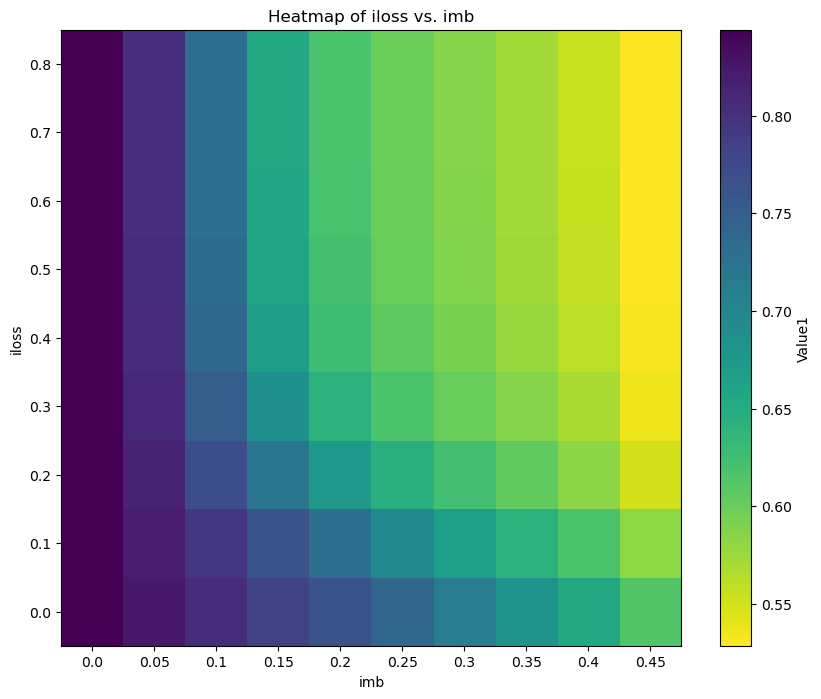

imb,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45
iloss,,,,,,,,,,
0.0,0.843956,0.822494,0.802729,0.783343,0.763294,0.740201,0.711993,0.682450,0.651919,0.613732
0.1,0.843956,0.819720,0.792613,0.762898,0.729601,0.695773,0.666555,0.642234,0.617601,0.581777
0.2,0.843956,0.812456,0.768863,0.720366,0.674590,0.644436,0.623747,0.605444,0.584008,0.550199
0.3,0.843956,0.807154,0.750788,0.685745,0.641598,0.617778,0.601433,0.586335,0.568014,0.536813
0.4,0.843956,0.804147,0.738797,0.666787,0.626966,0.606429,0.592297,0.577728,0.560236,0.531708
0.5,0.843956,0.802749,0.731962,0.658486,0.621073,0.602101,0.588146,0.574045,0.557140,0.529757
0.6,0.843956,0.802015,0.728969,0.655065,0.618981,0.600411,0.586549,0.572903,0.555968,0.528854
0.7,0.843956,0.801838,0.728552,0.653700,0.618441,0.599814,0.585947,0.572490,0.555593,0.528594
0.8,0.843956,0.801919,0.728426,0.653608,0.618116,0.599915,0.585749,0.572580,0.555443,0.528584


In [14]:
directory_run = 'outdata/20240525_run_IMPORTANT'
name_models = ['Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct', 'NEUROPULS_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell2_Arct']
name_model = 'NEUROPULS_Arct'

ave_devstd_run = np.load(directory_run+'/20240525_run_ave_dev_cos.npy', allow_pickle=True)
ave_devstd_df = pd.DataFrame(ave_devstd_run)
ave_devstd_df[['iloss', 'imb']] = ave_devstd_df['simulation'].apply(lambda x: pd.Series(extract_values(x)))
ave_devstd_filtered_model_df = ave_devstd_df[ave_devstd_df['model'] == name_model]
heatmap_data = ave_devstd_filtered_model_df.pivot_table(index='iloss', columns='imb', values='average')

# Plot the heatmap using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(heatmap_data, aspect='auto', cmap='viridis_r', origin='lower')
plt.colorbar(label='Value1')
plt.title('Heatmap of iloss vs. imb')
plt.xlabel('imb')
plt.ylabel('iloss')
# Set ticks for x and y axis
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)
plt.show()

heatmap_data

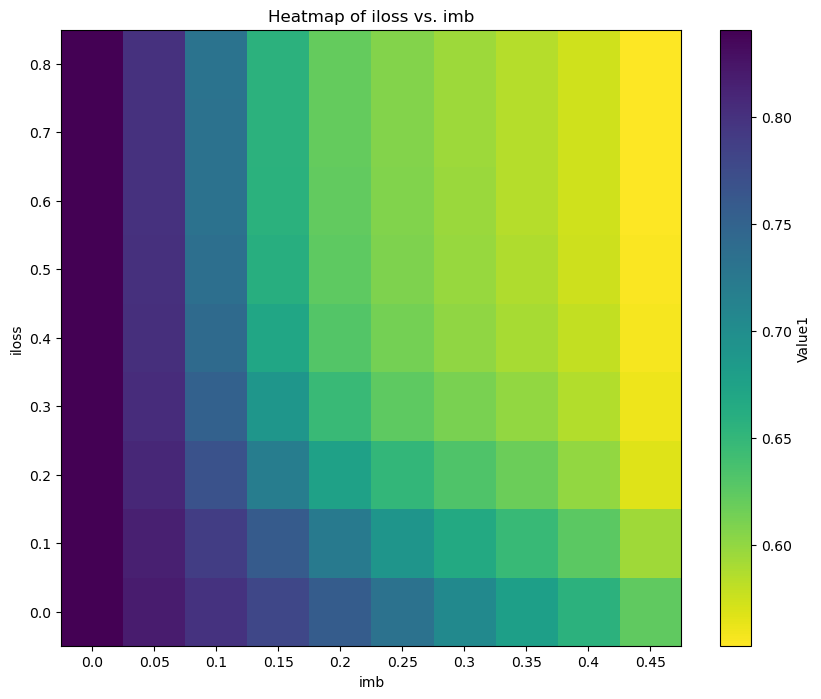

imb,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45
iloss,,,,,,,,,,
0.0,0.840730,0.818838,0.798759,0.779657,0.757075,0.732453,0.704276,0.677777,0.655765,0.623264
0.1,0.840730,0.815848,0.788744,0.758427,0.723652,0.690667,0.666395,0.646888,0.625865,0.593445
0.2,0.840730,0.809078,0.767794,0.718900,0.676183,0.649713,0.632241,0.617434,0.598927,0.566733
0.3,0.840730,0.804317,0.751642,0.689096,0.645223,0.624677,0.611191,0.599653,0.585983,0.560239
0.4,0.840730,0.802003,0.740853,0.669950,0.629893,0.613054,0.601161,0.590567,0.578691,0.556253
0.5,0.840730,0.800658,0.735051,0.660539,0.624247,0.608729,0.597007,0.586646,0.575266,0.554075
0.6,0.840730,0.800200,0.732476,0.656717,0.621891,0.606975,0.595638,0.585197,0.573799,0.553159
0.7,0.840730,0.799984,0.731665,0.655695,0.621316,0.606436,0.595116,0.584820,0.573397,0.552916
0.8,0.840727,0.800008,0.731101,0.655668,0.621058,0.605957,0.595042,0.584930,0.573371,0.552809


In [15]:
directory_run = 'outdata/20240525_run_IMPORTANT'
name_models = ['Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct', 'NEUROPULS_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell2_Arct']
name_model = 'NEUROPULSBell_Arct'

ave_devstd_run = np.load(directory_run+'/20240525_run_ave_dev_cos.npy', allow_pickle=True)
ave_devstd_df = pd.DataFrame(ave_devstd_run)
ave_devstd_df[['iloss', 'imb']] = ave_devstd_df['simulation'].apply(lambda x: pd.Series(extract_values(x)))
ave_devstd_filtered_model_df = ave_devstd_df[ave_devstd_df['model'] == name_model]
heatmap_data = ave_devstd_filtered_model_df.pivot_table(index='iloss', columns='imb', values='average')

# Plot the heatmap using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(heatmap_data, aspect='auto', cmap='viridis_r', origin='lower')
plt.colorbar(label='Value1')
plt.title('Heatmap of iloss vs. imb')
plt.xlabel('imb')
plt.ylabel('iloss')
# Set ticks for x and y axis
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)
plt.show()

heatmap_data

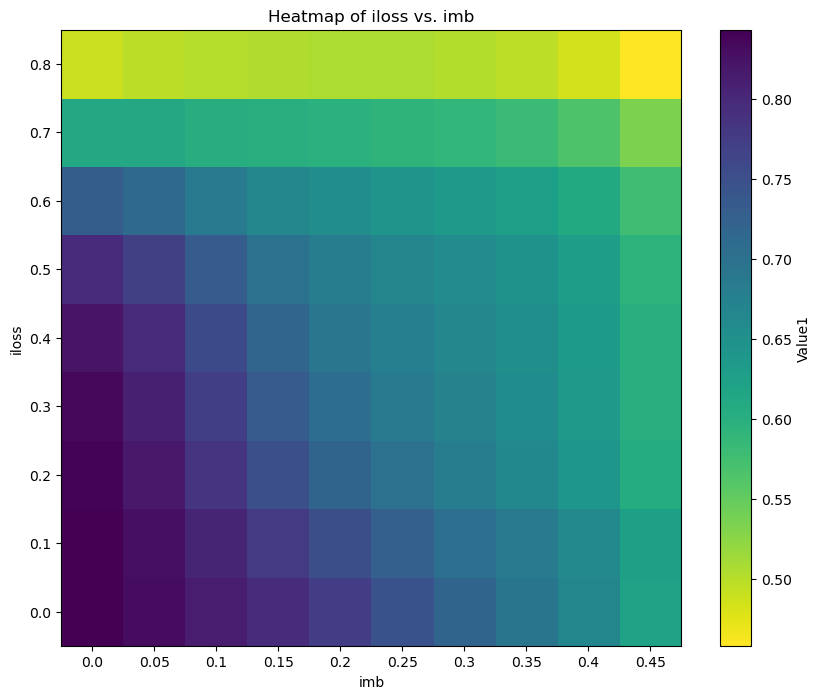

imb,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45
iloss,,,,,,,,,,
0.0,0.843491,0.831428,0.814129,0.795313,0.773383,0.747053,0.719464,0.694238,0.667535,0.622427
0.1,0.842788,0.827364,0.804045,0.778197,0.750451,0.724964,0.703323,0.685577,0.662469,0.624428
0.2,0.840382,0.817230,0.784310,0.749370,0.719536,0.698276,0.681589,0.663884,0.641425,0.604949
0.3,0.834940,0.809493,0.771935,0.732286,0.703872,0.685890,0.671001,0.656128,0.636439,0.602189
0.4,0.823270,0.796970,0.756490,0.718333,0.692948,0.677491,0.665017,0.651603,0.634004,0.601190
0.5,0.796163,0.770427,0.732077,0.700567,0.680118,0.668796,0.657750,0.645093,0.628057,0.595299
0.6,0.729499,0.710177,0.683585,0.665036,0.652924,0.644856,0.637183,0.626801,0.610129,0.576787
0.7,0.611588,0.610670,0.603078,0.599917,0.597034,0.593795,0.588524,0.580389,0.566378,0.534210
0.8,0.489431,0.498709,0.501760,0.504382,0.505723,0.505346,0.502584,0.496494,0.485343,0.458512


In [16]:
directory_run = 'outdata/20240525_run_IMPORTANT'
name_models = ['Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct', 'NEUROPULS_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell2_Arct']
name_model = 'NEUROPULSBell2_Arct'

ave_devstd_run = np.load(directory_run+'/20240525_run_ave_dev_cos.npy', allow_pickle=True)
ave_devstd_df = pd.DataFrame(ave_devstd_run)
ave_devstd_df[['iloss', 'imb']] = ave_devstd_df['simulation'].apply(lambda x: pd.Series(extract_values(x)))
ave_devstd_filtered_model_df = ave_devstd_df[ave_devstd_df['model'] == name_model]
heatmap_data = ave_devstd_filtered_model_df.pivot_table(index='iloss', columns='imb', values='average')

# Plot the heatmap using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(heatmap_data, aspect='auto', cmap='viridis_r', origin='lower')
plt.colorbar(label='Value1')
plt.title('Heatmap of iloss vs. imb')
plt.xlabel('imb')
plt.ylabel('iloss')
# Set ticks for x and y axis
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)
plt.show()

heatmap_data